### Classifying Urban sounds using Deep Learning

#### Visualizing Audio

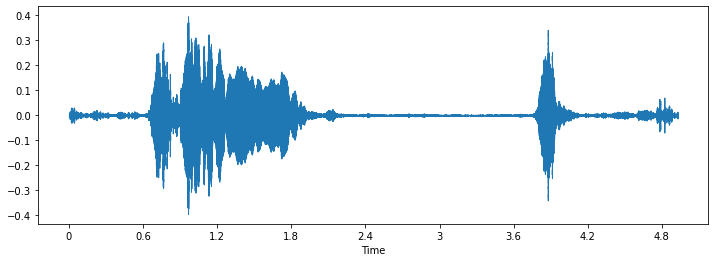

In [1]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import tarfile
from pathlib import Path
import pandas as pd
from tqdm import tqdm

current_directory = Path().parent.absolute()
example_bark = current_directory / "model" / "bark.wav"
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(example_bark)
_ = librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(example_bark)

#### Download & Unzip Dataset

In [2]:
# The dataset used is the UrbanSound8k dataset.
# There are multiple versions of this dataset, we are using the 2014 version which is available at https://zenodo.org/record/1203745
# Later versions changed the format significantly.

# Note: Due to attribution reasons we are not downloading it directly, you will need to insert the UrbanSounds8k.tar.gz into this directory.

tarfile.open(current_directory / 'UrbanSound8K.tar.gz').extractall(current_directory / 'model')
urbansounds_dir = current_directory / 'model' / 'UrbanSound8K'

# Set the path to the full UrbanSound dataset
fulldatasetpath = urbansounds_dir / 'audio/'
metadata = pd.read_csv(urbansounds_dir /  'metadata' / 'UrbanSound8K.csv')

#### Load Dataset

In [3]:
import numpy as np

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccsscaled

In [4]:
features = []
# This process will be a bit slow because it's single threaded
# Don't care enough to parallelise it.
for index, row in tqdm(metadata.iterrows(), total=metadata.__len__()):
    file_name = Path(fulldatasetpath) /  f'fold{str(row["fold"])}'  / str(row["slice_file_name"])
    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files')

 41%|████      | 3554/8732 [05:50<08:52,  9.73it/s]/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
 95%|█████████▌| 8325/8732 [13:39<00:39, 10.24it/s]/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
 95%|█████████▌| 8327/8732 [13:40<00:39, 10.28it/s]/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
 95%|█████████▌| 8329/8732 [13:40<00:38, 10.49it/s]/home/stephen/anacon

Finished feature extraction from  8732  files


#### Convert the data and labels

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
class_list = featuresdf['class']
y = np.array(class_list.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = keras.utils.to_categorical(le.fit_transform(y))

/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/dog-bark/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephen/anaconda3/envs/dog-bark

#### Split the dataset

In [6]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Training and Evaluation

In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Compile the model

In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [9]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

#### Training

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='model/weights.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6464/6985 [==========================>...] - ETA: 0s - loss: 10.1503 - acc: 0.1744
Epoch 00001: val_loss improved from inf to 2.19836, saving model to model/weights.hdf5
6985/6985 [==============================] - 0s 61us/sample - loss: 9.5963 - acc: 0.1735 - val_loss: 2.1984 - val_acc: 0.1940
Epoch 2/100
6496/6985 [==========================>...] - ETA: 0s - loss: 2.3161 - acc: 0.2203
Epoch 00002: val_loss improved from 2.19836 to 2.11447, saving model to model/weights.hdf5
6985/6985 [==============================] - 0s 47us/sample - loss: 2.3090 - acc: 0.2188 - val_loss: 2.1145 - val_acc: 0.2158
Epoch 3/100
5984/6985 [========================>.....] - ETA: 0s - loss: 2.1567 - acc: 0.2415
Epoch 00003: val_loss improved from 2.11447 to 1.98084, saving model to model/weights.hdf5
6985/6985 [==============================] - 0s 49us/sample - loss: 2.1441 - acc: 0.2445 - val_loss: 1.9808 - val_acc: 0.3108
Epoch 4/100
6624/6985 

#### Test the model

In [11]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9354331
Testing Accuracy:  0.8838008


#### Predictions

In [12]:
import librosa
import numpy as np

def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", example_bark)
        return None, None

    return np.array([mfccsscaled])

def print_prediction(file_name):
    prediction_feature = extract_feature(file_name)

    predicted_vector = np.argmax(model.predict(prediction_feature), axis=-1)
    predicted_class = le.inverse_transform(predicted_vector)
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = model.predict(prediction_feature)
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))

#### Validation

In [13]:
# Class: Dog Bark

filename = './model/bark.wav' 
print_prediction(filename)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00051949871703982353210449218750
car_horn 		 :  0.00037394475657492876052856445312
children_playing 		 :  0.10273420065641403198242187500000
dog_bark 		 :  0.50719779729843139648437500000000
drilling 		 :  0.01722040399909019470214843750000
engine_idling 		 :  0.00075464823748916387557983398438
gun_shot 		 :  0.32348555326461791992187500000000
jackhammer 		 :  0.00000307119603348837699741125107
siren 		 :  0.04041061550378799438476562500000
street_music 		 :  0.00730026699602603912353515625000
